<h1> ALL MODELS IN ONE NOTEBOOK

<h1> Prophet

<h3>IMPORTS

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt
from pandas_profiling import ProfileReport
from matplotlib import pyplot
import datetime
from datetime import date
import calendar
from calendar import monthrange
import fbprophet

import holidays

In [2]:
list_df=[]
list_of_dates=[]
by_day_df = pd.DataFrame()


#get csv files and sort them
csv_files = glob.glob("*.csv")
csv_files.sort(key=os.path.getctime)

date_time_str = '2019-11-01 04:00:00'
date_time_start = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

date_time_str = '2019-11-01'
date_time_first = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

date_time_str = '2020-01-31'
date_time_end = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

date_list= pd.date_range(date_time_first , date_time_end, freq='D')


austria_holidays = holidays.CountryHoliday('AT', prov=1)

austria_holidays = austria_holidays['2019-11-01': '2020-11-01']

austria_holidays = date_list.isin(austria_holidays)

#Kapazität des Busmodells 15A - Mercedes Benz Citaro GNG 265 MB
kapaz = 129
    
for i, filename in enumerate (csv_files):
    
    #print(i, filename)
    
    #read the data and dont take the last column
    puffer_df= pd.read_csv(filename, index_col=None, header= 0,usecols=[0,1,2,3],decimal = ",", delimiter=";")

#     print(puffer_df)
    
    #DATUM
    
    for k in range (4,25):

        if k == 24 :
            #Zeit ist statt 24 am nächsten halt 23:59:59
            date_time_start = date_time_start.replace(hour = 23, minute = 59, second = 59)

        else:
            #datum ist nun um eine Stunde vorgestellt
            date_time_start = date_time_start.replace(hour = k)

        #HIER muss es zugewiesen werden bevor die stunde wieder verändert wird!!!!
        list_of_dates.append(date_time_start)
            
        
    puffer_df.insert(0,'Datum',list_of_dates)
    list_of_dates.clear()

    last_of_month = monthrange(date_time_start.year, date_time_start.month)[1]  

    if date_time_start.month != 12 and date_time_start.day == last_of_month:
        
        date_time_start = date_time_start.replace(month = date_time_start.month + 1, day = 1, hour = 4 , minute = 0, second = 0)
    
    elif date_time_start.month == 12 and date_time_start.day == last_of_month:
        
        date_time_start = date_time_start.replace(year = date_time_start.year +1, month = 1, day = 1, hour = 4 , minute = 0, second = 0)
    
    else:
        date_time_start = date_time_start.replace(day = date_time_start.day + 1, hour = 4 , minute = 0, second = 0)
        
    #ENDE von DATUM
    
    
    puffer_df.insert(1,'Wochentag',calendar.day_name[date_list[i].weekday()])
    puffer_df.insert(6,'min_kapaz',puffer_df['Istfahrtenzahl']*kapaz)
    puffer_df.insert(7,'Feiertag',austria_holidays[i].astype(int))
    


    #vor dem Berechnen die NAN VALUES mit '0' ersetzen
    puffer_df.fillna(0, inplace = True)
    
    #stuff für die monats dataframe
    summe = puffer_df['P hochgerechnet'].sum()
    summesoll = puffer_df['Sollfahrtenzahl'].sum()
    summeist = puffer_df['Istfahrtenzahl'].sum()
    prozent = float(summeist/summesoll)*100
    kapaz_daily = summeist*kapaz
    
    

    row_month = {'datum': date_list[i], 'datum_tag': calendar.day_name[date_list[i].weekday()],
                 'eingänge_pro_tag': summe, 'fahrten_pro_tag_soll':summesoll, 'fahrten_pro_tag_ist':summeist,
                 'genauigkeit_pro_tag':prozent,'kapazität_täglich':kapaz_daily, 'tag=feiertag':austria_holidays[i].astype(int) }
    
    by_day_df = by_day_df.append(row_month , ignore_index = True)
    
    list_df.append(puffer_df) #!!!!
    
    by_hour_df = pd.concat(list_df, ignore_index = True)
    
    #print(puffer_df)
    #print(summe,summesoll,summeist,prozent)

by_day_df = by_day_df.reindex(columns=['datum','datum_tag','eingänge_pro_tag','fahrten_pro_tag_soll','fahrten_pro_tag_ist','genauigkeit_pro_tag','kapazität_täglich','tag=feiertag'])

In [3]:
training = by_hour_df.iloc[0:1554]
test = by_hour_df.iloc[1554:]

In [4]:
columns_to_drop = ["Wochentag","Feiertag","Tageszeit","Sollfahrtenzahl","Istfahrtenzahl","min_kapaz"]

training = training.drop(columns= columns_to_drop)
test = test.drop(columns= columns_to_drop)

<h2> Plot von Training und Test, Unterschied

In [5]:
from matplotlib import pyplot
%matplotlib qt

print('Observations: %d' % (len(by_hour_df)))
print('Training Observations: %d' % (len(training)))
print('Testing Observations: %d' % (len(test)))

pyplot.plot(training["P hochgerechnet"])
pyplot.plot([None for i in training["P hochgerechnet"]] + [x for x in test["P hochgerechnet"]])
pyplot.xlabel("Anzahl der Beobachtungen")
pyplot.ylabel("Eingänge der Passagiere")
pyplot.title("Visualisierung der Training- und Testdaten")

pyplot.show()


Observations: 1932
Training Observations: 1554
Testing Observations: 378


<h2> Vorbereitungen für Prophet

In [6]:
training.rename(columns={'Datum': 'ds', 'P hochgerechnet': 'y'}, inplace = True)

In [7]:
test.rename(columns={'Datum': 'ds', 'P hochgerechnet': 'y'}, inplace = True)

In [8]:
austria_holidays = holidays.CountryHoliday('AT', prov=1)

austria_holidays = austria_holidays['2019-11-01': '2020-11-01']

In [9]:
austria_holidays = pd.DataFrame({
  'holiday': 'feiertage',
  'ds': austria_holidays
})

<h2> Vorhersage basierend auf historischen Daten (trainings-set)

In [13]:
# Make the prophet model and fit on the data
training_prophet = fbprophet.Prophet(holidays = austria_holidays, changepoint_prior_scale=0.05, daily_seasonality = True , weekly_seasonality = True, yearly_seasonality = False)
training_prophet.fit(training)

In [14]:
# Make a future dataframe for .. hours, days, years
training_forecast = training_prophet.make_future_dataframe(periods=360, freq='H')

#entweder auf historie -> training_forecast oder auf test_set
training_forecast = training_prophet.predict(training_forecast)


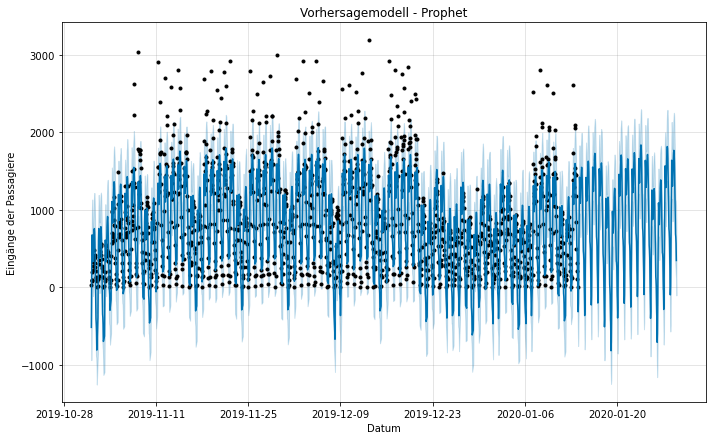

In [15]:
training_prophet.plot(training_forecast, xlabel = 'Datum', ylabel = 'Eingänge der Passagiere')
plt.title('Vorhersagemodell - Prophet');

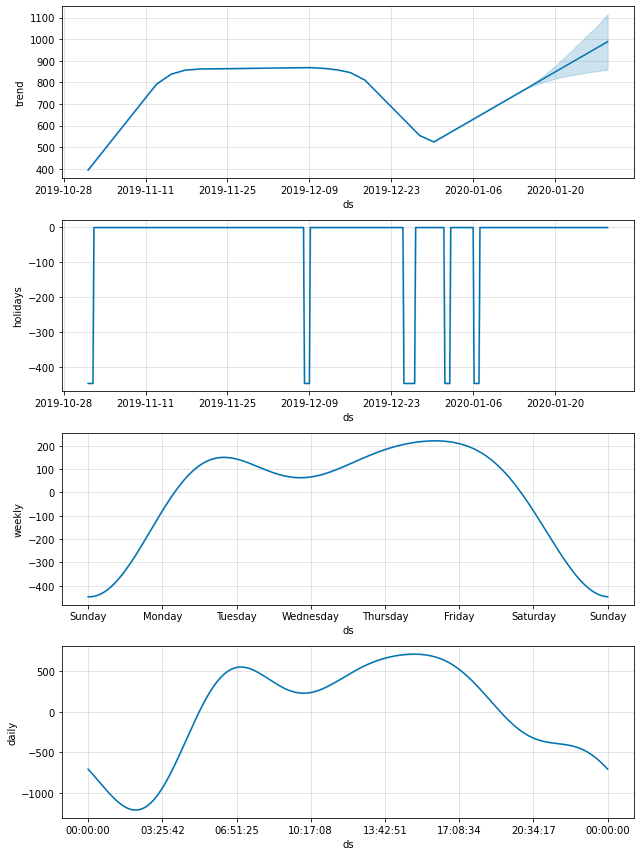

In [16]:
training_prophet.plot_components(training_forecast,uncertainty = True);

<h2> Vorhersage basierend auf test-set

In [10]:
# Make the prophet model and fit on the data
training_prophet_aufTest = fbprophet.Prophet(holidays = austria_holidays, changepoint_prior_scale=0.05, daily_seasonality = True , weekly_seasonality = True, yearly_seasonality = False)
training_prophet_aufTest.fit(training)


In [11]:
%timeit -n 1 -r 1 training_prophet_aufTest.predict(df=test.reset_index() \
                                   .rename(columns={'Datum':'ds'}))

1.11 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
# Predict on test set
training_forecast_aufTest = training_prophet_aufTest.predict(df=test.reset_index() \
                                   .rename(columns={'Datum':'ds'}))

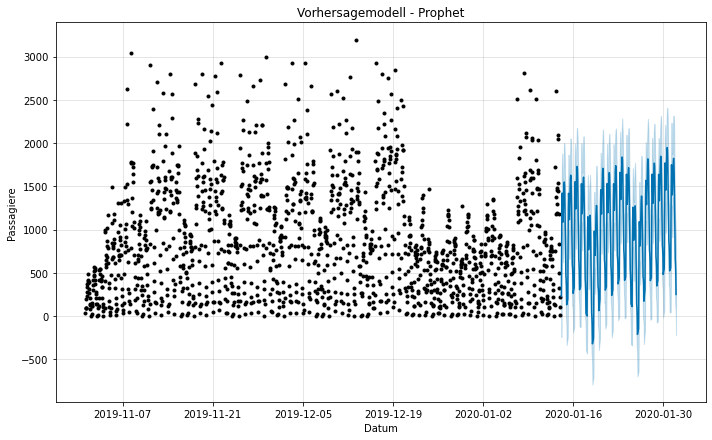

In [101]:
training_prophet_aufTest.plot(training_forecast_aufTest, xlabel = 'Datum', ylabel = 'Passagiere')
plt.title('Vorhersagemodell - Prophet');

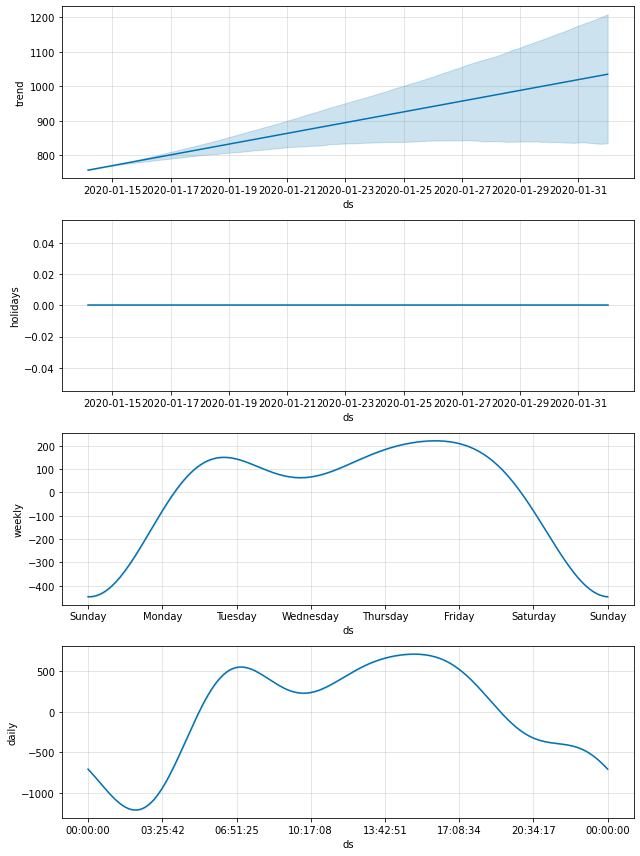

In [102]:
training_prophet_aufTest.plot_components(training_forecast_aufTest,uncertainty = True);

In [29]:
from sklearn.metrics import r2_score, mean_absolute_error

In [31]:
r2_score(training["P hochgerechnet"],training_forecast["yhat"])

0.07085952897352926

<h1> LSTM

<h3>IMPORTS

In [13]:
import os
import glob
import numpy as np
import pandas as pd

import datetime
import calendar
import holidays
from datetime import date
from calendar import monthrange
from matplotlib import pyplot
import matplotlib.pylab as plt

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

%matplotlib inline

In [15]:
training_set = by_hour_df.iloc[0:1554, 5:6].values
test_set = by_hour_df.iloc[1554:, 5:6].values

Normalisierung

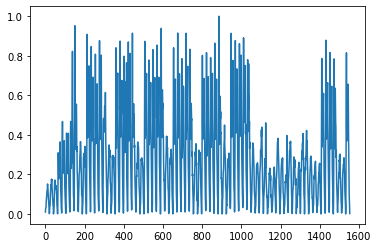

In [16]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

pyplot.plot(training_set_scaled)

Strukturerstellung für die Lag/Timesteps

In [17]:
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []

for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-50:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [18]:
print(X_train.shape)

(1494, 50, 1)


In [ ]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
%timeit -n 1 -r 1 model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
%timeit -n 1 -r 1 model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
%timeit -n 1 -r 1 model.add(LSTM(units = 50, return_sequences = True))
%timeit -n 1 -r 1 model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
%timeit -n 1 -r 1 model.add(LSTM(units = 50, return_sequences = True))
%timeit -n 1 -r 1 model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
%timeit -n 1 -r 1 model.add(LSTM(units = 50))
%timeit -n 1 -r 1 model.add(Dropout(0.2))

# Adding the output layer
%timeit -n 1 -r 1 model.add(Dense(units = 1))

# Compiling the RNN
%timeit -n 1 -r 1 model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
%timeit -n 1 -r 1 model.fit(X_train, y_train, epochs = 100, batch_size = 32)

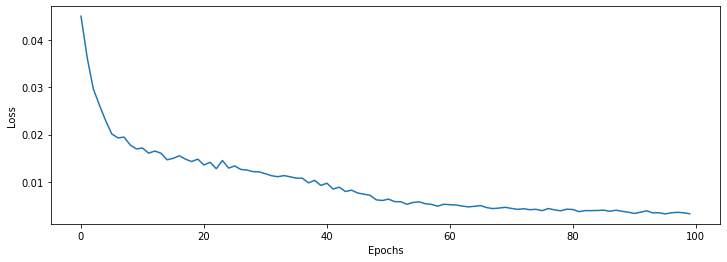

In [20]:
losses_lstm = model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [21]:
dataset_train = by_hour_df.iloc[0:1554, 5:6]
dataset_test = by_hour_df.iloc[1554:, 5:6]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
print(len(dataset_total) - len(dataset_test) - 60)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

print(inputs.shape[0])

1494
438


In [22]:
X_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-50:i, 0])
    


X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)

(378, 50, 1)


In [23]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

<h2> Vergleich der echten Werte und Vorhersage LSTM

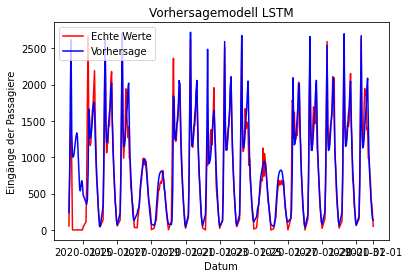

In [25]:
# Visualising the results
plt.plot(by_hour_df.loc[1554:, "Datum"],dataset_test.values, color = "red", label = "Echte Werte")
plt.plot(by_hour_df.loc[1554:, "Datum"],predicted_stock_price, color = "blue", label = "Vorhersage")

plt.title('Vorhersagemodell LSTM')
plt.xlabel('Datum')
plt.ylabel('Eingänge der Passagiere')
plt.legend()
plt.show()

<h1> ARIMA

<h3>IMPORTS

In [26]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import datetime
from datetime import date

import calendar
from calendar import monthrange
import holidays

from pandas_profiling import ProfileReport
import itertools

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tools.eval_measures import rmse
import warnings

%matplotlib inline

In [41]:
training = by_hour_df.iloc[0:1554]
test = by_hour_df.iloc[1554:]

In [42]:
training = training.drop(columns= ["Wochentag","Feiertag","Tageszeit","Sollfahrtenzahl","Istfahrtenzahl","min_kapaz"])
test = test.drop(columns= ["Wochentag","Feiertag","Tageszeit","Sollfahrtenzahl","Istfahrtenzahl", "min_kapaz"])



In [ ]:
training = training.set_index('Datum')
training.index

In [ ]:
test = test.set_index('Datum')
test.index

In [32]:
test = test['P hochgerechnet'].resample('H').mean()
training = training['P hochgerechnet'].resample('H').mean()

test = test.fillna(0)
training = training.fillna(0)

In [33]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


<h3> Ermittlung der Parameter für p,d,q

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.arima.ARIMA(training,
                                     order=param,
                                     seasonal_order=param_seasonal,
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
# ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:22326.706471523285


<h3>Fit prozess ARIMA

In [ ]:
mod = sm.tsa.arima.ARIMA(training, order=(1, 1, 6), seasonal_order=(1, 1, 2, 12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
# print(results.summary().tables[1])
# #order=(1, 1, 6),seasonal_order=(1, 1, 2, 12),

In [35]:
print(results.summary())

                                       SARIMAX Results                                       
Dep. Variable:                       P hochgerechnet   No. Observations:                 1772
Model:             ARIMA(1, 1, 6)x(1, 1, [1, 2], 12)   Log Likelihood              -12540.296
Date:                               Sun, 23 May 2021   AIC                          25102.592
Time:                                       12:29:10   BIC                          25162.594
Sample:                                   11-01-2019   HQIC                         25124.787
                                        - 01-13-2020                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9370      0.206      4.554      0.000       0.534       1.340
ma.L1      

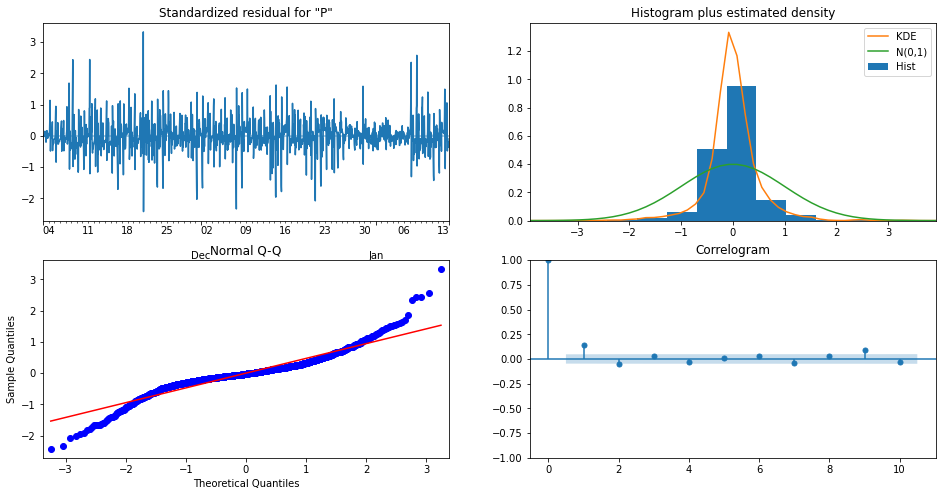

In [54]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()


In [37]:
pred = results.predict(start=pd.to_datetime('2020-01-14'), end=pd.to_datetime('2020-02-01'))

<h1> Alle Modellergebnisse mit realen Passagierdaten verglichen

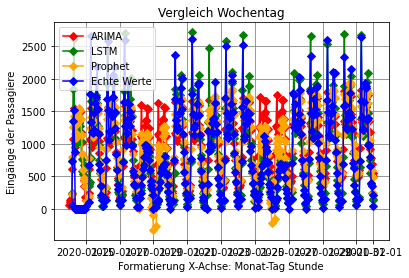

In [60]:
plt.plot(pred, color= "red", label ="ARIMA", marker="D")
plt.plot(by_hour_df.loc[1554:, "Datum"],predicted_stock_price, color="green" ,label = "LSTM", marker="D")
plt.plot(training_forecast_aufTest.index,training_forecast_aufTest["yhat"] ,color= "orange", label ="Prophet", marker="D")
plt.plot(test.index, test["P hochgerechnet"],color = "blue", label="Echte Werte", marker="D")
plt.title('Vergleich Wochentag')
plt.xlabel('Formatierung X-Achse: Monat-Tag Stunde')
plt.ylabel('Eingänge der Passagiere')
plt.grid(color='grey')
plt.legend() 
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
plt.show()

<h2> -> Genauere Beobachtung der Ergebnisse siehe Bachelorarbeit

<h2>Kapazität und LSTM

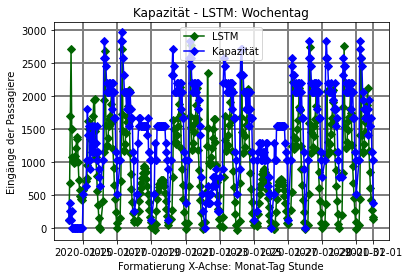

In [113]:
plt.plot(by_hour_df.loc[1554:, "Datum"],predicted_stock_price,color="darkgreen" ,label = "LSTM", marker="D")
plt.plot(by_hour_df.loc[1554:, "Datum"],by_hour_df.loc[1554:, "min_kapaz"],color = "blue", label="Kapazität", marker="D")
plt.title('Kapazität - LSTM: Wochentag')
plt.xlabel('Formatierung X-Achse: Monat-Tag Stunde')
plt.ylabel('Eingänge der Passagiere')
plt.grid(color='grey', linewidth=2)
plt.legend()  

plt.show()




<h2> Welches Modell hat die niedrigste Differenz zu den echten Werten?

In [37]:
# len(pred)
# pred.index[21]
# pred.drop(pred.index[22])

# if pred.index != test.index:
#     print("yes")
# pred.tail(40)
# type(pred)
# pred[pred.index != 'Tina']
# # print(len(arima_df),len(test),len(predicted_stock_price),len(training_forecast_aufTest))
# # training_forecast_aufTest.tail()
# for i, wert in enumerate(test):
#     print(wert)
#     print(type(wert))
# arima_df["predicted_mean"][0]

for i in range(0,428):
    
    if  pred.index[i] not in test.index:
        print(pred.index[i])
        pred = pred.drop(pred.index[i])
        
        
pred.to_csv("pred.csv")

In [39]:
#get csv files and sort them
csv_files = glob.glob("*.csv")
csv_files.sort(key=os.path.getctime)

arima_df= pd.read_csv('pred.csv', index_col=None, header= 0,decimal = ".", delimiter=",")

arima_df

,Unnamed: 0,predicted_mean
0,2020-01-14 04:00:00,232.004992
1,2020-01-14 05:00:00,610.346842
2,2020-01-14 06:00:00,1069.195109
3,2020-01-14 07:00:00,1553.696137
4,2020-01-14 08:00:00,1040.129788
...,...,...
373,2020-01-31 20:00:00,917.771913
374,2020-01-31 21:00:00,780.238633
375,2020-01-31 22:00:00,695.552654
376,2020-01-31 23:00:00,550.283590


In [55]:
print(len(predicted_stock_price))
print(len(test))
print(len(training_forecast_aufTest))
print(len(arima_df))

378
378
378
378


<h1> Differenz - Endwerte

In [ ]:
vergleich_df = pd.DataFrame()


for i in range(0,378):
    
    row_vergleich = {'Testset': test["P hochgerechnet"][i], 
                     'Prophet': (abs(np.diff( [test["P hochgerechnet"][i], training_forecast_aufTest["yhat"][i]])[0])),
                     'LSTM': (abs(np.diff( [test["P hochgerechnet"][i], predicted_stock_price[i][0]])[0])), 
                     'ARIMA': (abs(np.diff( [test["P hochgerechnet"][i], arima_df["predicted_mean"][i]])[0])) }
    
    print("Erwartet: ", test["P hochgerechnet"][i])
    print("Differenz dazu:", 
          (abs(np.diff( [test["P hochgerechnet"][i], training_forecast_aufTest["yhat"][i]])[0])),
          (abs(np.diff( [test["P hochgerechnet"][i], predicted_stock_price[i][0]])[0])), 
          (abs(np.diff( [test["P hochgerechnet"][i], arima_df["predicted_mean"][i]])[0])))
    
    vergleich_df = vergleich_df.append(row_vergleich , ignore_index = True)

In [286]:
print("Summe der Differenzen zum Test-Set")
print("LSTM: \t", vergleich_df["LSTM"].sum())
print("Prophet: ", vergleich_df["Prophet"].sum())
print("ARIMA: \t", vergleich_df["ARIMA"].sum())

Summe der Differenzen zum Test-Set
LSTM: 	 68051.47362212754
Prophet:  119227.57856466262
ARIMA: 	 132266.3478219547


<h2>RMSE - Endwerte

In [179]:
from sklearn.metrics import mean_squared_error

In [213]:
prophet_error = mean_squared_error(test["P hochgerechnet"],training_forecast_aufTest["yhat"], squared = False)
print("Prophet RMSE ERROR: ", prophet_error )

Prophet RMSE ERROR:  414.7687854288369


In [285]:
print("Prophet MSE:")
np.square(np.subtract(test["P hochgerechnet"].values,training_forecast_aufTest["yhat"].values)).mean()

Prophet MSE:


172033.14536611256

In [269]:
lstm_error = mean_squared_error(test["P hochgerechnet"],predicted_stock_price, squared = False)
print("LSTM RMSE ERROR: ", lstm_error )

LSTM RMSE ERROR:  340.1841462147975


In [275]:
print("LSTM MSE:")
np.square(np.subtract(test["P hochgerechnet"].values,predicted_stock_price[0][0])).mean()

LSTM MSE:


790437.1420288807

In [228]:
arima_error = mean_squared_error(test["P hochgerechnet"],arima_df["predicted_mean"], squared = False)
print("ARIMA RMSE ERROR: ", arima_error )

ARIMA RMSE ERROR:  460.3343319325193


In [232]:
print("ARIMA MSE:")
np.square(np.subtract(test["P hochgerechnet"].values,arima_df["predicted_mean"].values)).mean()

ARIMA MSE:


211907.69715575885